# UGW Tutorial

To do:
- delete? coupling matrix visuals
- decide on last ex
- continue latexing

In this tutorial, we will examine how to use Gromov-Wasserstein (GW) and unbalanced Gromov-Wasserstein (UGW) to align a CITEseq dataset, which has co-assayed antibody and gene expression data on 7985 human/mouse blood cells. We select 1000 human samples from this dataset, and split the data into two matrices: one that contains antibody information on these samples and another that contains gene expression information on the same samples. The goal in this tutorial (as well as UCOOT) will be to recover which sample matches with which sample using optimal transport. So, we are trying to recover a 1-1 mapping that we know exists.

```{note}
Before beginning this tutorial, note that it serves more as an introduction to UCOOT by showing a specific application (UGW), as well as setting up intuition for SCOOTR later on. UCOOT is a generalized version of UGW, and UGW can be directly recovered by making the right choices for the inputs to UCOOT. So, if you want a more detailed tutorial of the generalized version, go to the UCOOT tutorial. This tutorial goes into a little bit more detail on the specifics of each hyperparameter, but leaves some of the potential steps to the UCOOT tutorial.
```

```{tip}
If you have not yet configured a SCOOTR directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a SCOOTR object mean, try our setup tutorial for getting used to using the tool. We use the default parameters for this tutorial.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you are already comfortable with UGW, try moving on to our UCOOT tutorial.
```

### Data download

If you wish to work with the raw PBMC_ADT and PBMC_RNA files from the CITE-seq dataset (we will use the mostly preprocessed ones), run the following commands in the terminal in the root directory of this tutorial repository:

<center> sh ./download_scripts/CITEseq_download.sh </center>

If you download the code manually instead, make sure to produce the same file structure - i.e., there should be a data directory with a CITEseq subdirectory containing your csv files. This folder should already be populated with our two preprocessed datasets.

### Preprocessing

We will start with some mild preprocessing, such as loading the preprocessed datasets into variables local to this notebook. We begin by setting up pytorch. Use this as is, unless you would like to try a different device.

In [1]:
import torch
print('Torch version: {}'.format(torch.__version__))
print('CUDA available: {}'.format(torch.cuda.is_available()))
print('CUDA version: {}'.format(torch.version.cuda))
print('CUDNN version: {}'.format(torch.backends.cudnn.version()))

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark=True

Torch version: 2.0.1
CUDA available: False
CUDA version: None
CUDNN version: None


In these tutorials, we omit the exact preprocessing steps for this dataset. However, if you would like to replicate the steps in the appendix of Tran et al., implement your preprocessing of the raw datasets here. Use the shape attribute for ndarrays/dataframes/anndata to get a sense for how large these datasets are.

In [2]:
%%capture
import src.scootr as scoot
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import normalize

X_raw = sc.read_csv("./data/CITEseq/citeseq_adt_normalized_1000cells.csv")
y_raw = sc.read_csv("./data/CITEseq/citeseq_rna_normalizedFC_1000cells.csv")
x_feat_labels=["CD11a","CD11c","CD123","CD127-IL7Ra","CD14","CD16","CD161","CD19","CD197-CCR7","CD25","CD27","CD278-ICOS","CD28","CD3","CD34","CD38","CD4","CD45RA","CD45RO","CD56","CD57","CD69","CD79b","CD8a","HLA.DR"]
y_feat_labels=["ITGAL","ITGAX","IL3RA","IL7R","CD14","FCGR3A","KLRB1","CD19","CCR7","IL2RA","CD27","ICOS","CD28","CD3E","CD34","CD38","CD4","PTPRC","PTPRC","NCAM1","B3GAT1","CD69","CD79B","CD8A","HLA-DRA"] 
samp_labels = ['Cell {0}'.format(x) for x in range(X_raw.shape[1])]


```{note}
In order to examine further how exactly UGW alignment works later on in this tutorial, we examine a subset of 10 of the 25 gene-antibody pairs.
```

In [3]:
# l2 normalization of both datasets, which we found to help with single cell applications
X_full_annotated = pd.DataFrame(normalize(normalize(X_raw.X, norm='l2', axis=1).transpose(), norm='l2', axis=1))
X_full_annotated.index, X_full_annotated.columns = samp_labels, x_feat_labels
y_full_annotated = pd.DataFrame(normalize(y_raw.transpose().X, norm='l2', axis=1))
y_full_annotated.index, y_full_annotated.columns = samp_labels, y_feat_labels

X_full = X_full_annotated.to_numpy()
y_full = y_full_annotated.to_numpy()

X_annotated = X_full_annotated.iloc[:,0:10]
y_annotated = y_full_annotated.iloc[:,0:10]

X = X_annotated.to_numpy()
y = y_annotated.to_numpy()


Now that we have our data, we visualize it with two dimensionality reduction techniques: UMAP and PCA. These visualization techniques can be helpful for visualizing any intermediate steps through this project, although our eventual coupling matrices are better visualized with a heatmap.

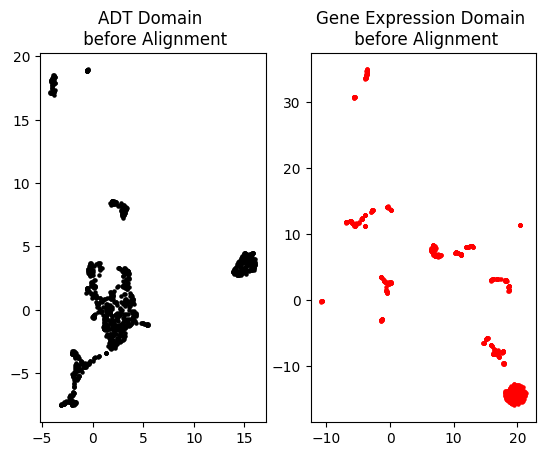

In [4]:
um = umap.UMAP(random_state=0);

originalX_um=um.fit_transform(X)
originaly_um=um.fit_transform(y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_um[:,0], originalX_um[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(originaly_um[:,0], originaly_um[:,1], c="r", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

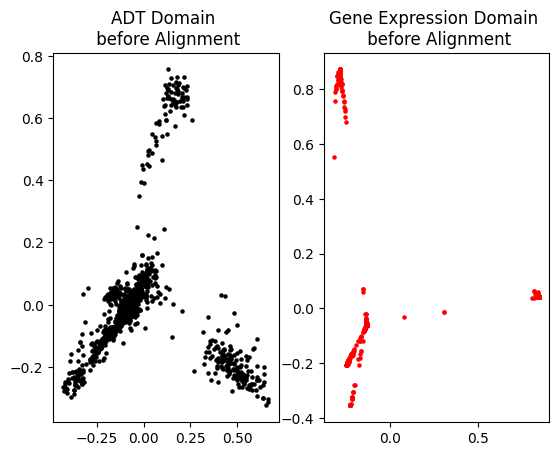

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca=PCA(n_components=2)

originalX_pca=pca.fit_transform(X)
originaly_pca=pca.fit_transform(y)

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=5)
ax1.set_title("ADT Domain \n before Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=5)
ax2.set_title("Gene Expression Domain \n before Alignment")
plt.show()

### Converting Datasets to Distance Matrices

In this tutorial, we will go over how to use a SCOOTR object to align your data using UGW. UGW is a simpler form of UCOOT, which seeks only to minimize the transport cost for samples, and ignores the problem of aligning features. We can begin by instantiating a SCOOTR object.

In [6]:
scootr = scoot.SCOOTR()

In the case of UGW, the goal is to generate one coupling matrix, matching samples from one domain to samples of the other. UGW treats the samples of each experiment as two probability distributions (one for each experiment) and finds the coupling matrix that determines the most cost-efficient way to move mass from one distribution to the other. So, UGW will produce a matrix that determines how much mass of a sample in one domain should go to each sample in the other domain (values seen across each sample's respective row or column). This matrix is then used to project data from one domain into the other.

In order to do this, UGW seeks to minimize the cost of transporting each pair of points onto each other pair of points. In particular, for a given $x_a$ and $x_b$ in one domain and a given $y_a$ and $y_b$ in the other domain, UGW calculates the cost of transporting $x_a$ and $x_b$ to $y_a$ and $y_b$: $L(D(x_a, x_b), D(y_a, y_b)) \cdot \pi_{x_a, y_a} \cdot \pi_{x_b, y_b}$, where $L$ is a given cost function and $D$ is some measure of intra-domain distance (in our case, l2 distance or nearest-neighbor connectivity). So, UGW seeks to select $\pi$ to minimize these costs summed across all pairs of points in each domain. Looking at this cost function, we can see that UGW penalizes matching a pair of points based on some measure of the difference in pairwise distances; i.e., UGW seeks to maintain local geometry. As another way of thinking about it, UGW encourages a large $\pi_{xy}$ if $x$ and $y$ have similar "locations" relative to the rest of their domain.

Looking at the cost function again, we can see that UGW requires us to know the distance between each pair of points resting in the same domain. In fact, we input these distance matrices to UGW in order to make our alignments. Let's look at a few different ways we can calculate these distance matrices:

In [7]:
# l2 distance
Dx_l2 = torch.cdist(torch.from_numpy(X).to(device), torch.from_numpy(X).to(device), p=2)**2
Dy_l2 = torch.cdist(torch.from_numpy(y).to(device), torch.from_numpy(y).to(device), p=2)**2

# knn connectivity distance
Dx_knn, Dy_knn = torch.from_numpy(scootr.knn_dist(X, 50).astype('float32')).to(device), torch.from_numpy(scootr.knn_dist(y, 50).astype('float32')).to(device)

### Default UGW

Now, we will start with an example of UGW using its default parameters, followed by a completed alignment. Note that, to complete an alignment, we must use the produced coupling matrix to project the samples in one domain into the other. Since we use euclidean distance to penalize the difference in pairwise distances ($L$ function in the cost in the previous section), this projection, for a given $y_a$ in the domain we are seeking to project, takes the row/column-wise (depending on the orientation of $\pi$) weighted average associated with $y_a$:

$y_a$ projected onto $X = \frac{\Sigma_{i=1}^{n_x}(x_i*\pi_{x_i,y_a})}{\Sigma_{i=1}^{n_x} (\pi_{x_i,y_a})}$

Once this process is completed for all $y_j$, we recover UGW's predicted values for the cells from domain $y$ on the features of domain $X$. In a separately assayed example (not as trivial like this case), this alignment will give us the measurement for every feature in $X$ and $y$ on the sample set of $y$ – we have the measured values on $y$'s features and the predicted values on $X$'s features. Let's see this workflow in action (UGW followed by projection) using UGW's default parameters (except for a change in $\epsilon$, which we will examine later). Then, we will move on to the two main hyperparameters for this method. Note that for now, we will stick to KNN distance.

In [8]:
# set verbose=True to get a breakdown of the cost progression during optimization
# set log=True to get extra return values, log_cost and log_ent_cost, which display the cost progression
(pi_samp_1, pi_samp_2), duals, log_cost, log_ent_cost = scootr.solver_fgw(Dx_knn, Dy_knn, eps=1e-4, verbose=True, log=True)

Cost at iteration 1: 0.03323853015899658


Cost at iteration 6: 0.01691684126853943


Cost at iteration 11: 0.01679953932762146


Cost at iteration 16: 0.016788393259048462


Cost at iteration 21: 0.01678478717803955


Cost at iteration 26: 0.016783297061920166


In the above code, notice that we get back a lot more than just a singular coupling matrix. Since we solve for UGW using a generalized process that we also use to solve UCOOT (generates two coupling matrices), we end up with multiple coupling matrices; however, these coupling matrices should be very similar, considering the matrices we input to the process are symmetric across the diagonal. In other words, since our samples and features are the "same" with these distance matrices, our sample coupling matrix and feature coupling matrix should be similar, and both represent a sample coupling matrix (since we generated our distance matrices with sample data). This idea will make a little more sense once you reach the UCOOT tutorial. These two coupling matrices are pi_samp_1 and pi_samp_2 above.

Next, we also get back the duals. The duals relate to the optimization process we use to solve for the coupling matrices; in particular, they are a biproduct of the Sinkhorn algorithm, one of our methods for OT iteration. The way we solve for the coupling matrix involves iteratively running Sinkhorn (or another OT algorithm) on one of the coupling matrices, followed by doing the same on the other, as described in the setup tutorial. Sinkhorn iteratively solves for two duals, which, when multiplied (dual_1 * primal * dual_2) by a primal matrix that we initialize, recover the current coupling matrix being optimized. Since we switch between optimizing one coupling matrix and the other, we end up with 4 duals at the end of optimization. As a result, if you unpack the duals variable above, it is of the shape (\_,\_), (\_,\_).

The next two results we get are only present if we set log=True. If we were to set log=false, we would only have two values to unpack in the above code. However, if log=True, we also get back a log of the transport cost (log_cost) in addition to the log of the entropic + transport cost (log_ent_cost) as a list. We will go over entropic cost in the next subsection of this tutorial. For now, we move on to the application of these coupling matrices: alignment.

```{warning}
Be careful how you order your matrices between UGW and alignment. pi_samp will have the samples of the first matrix you input on its vertical axis and the samples of the second matrix you input on its horizontal axis. Our get_barycentre method takes in the anchor domain (the one you want to project onto) and assumes that the anchor domain samples are on the vertical axis during projection. Therefore, make sure to put your desired anchor domain first in the previous step. So, if we want to project y onto X, (as we are doing in this case), we put X before y above, and then pass in X to get_barycentre. We then get back our aligned y.
```

In [9]:
aligned_y = scootr.get_barycentre(torch.from_numpy(X).to(device), pi_samp_1)

From here, we can score the alignment. Note that we generated $X$ and $y$ such that they contain data on the same set of 1000 cells (co-assayed); this means that, in a perfect alignment, aligned_y would be identical to $X$. So, we can score aligned_y based on some measure of how close it is to $X$. To do this, we use FOSCTTM (fraction of samples closer than true match) as described in the UGW tutorial. In order to calculate a score, for each sample $x$ in $X$, we compute a ranking of how close (l2 distance) each sample in aligned_y is to $x$. From here, we find the index at which the true match for $x$ falls within this sorted ranking. This index tells us how many samples in aligned_y are closer to $x$ than its true match, which is a measure of how well the alignment matched samples in y to $x$. By taking the average of these scores across all $x$, we can get a sense for how good the alignment was. The lower the FOSCTTM, the better.

```{note}
In this tutorial, we are not going for perfect alignments; rather, we are trying to get some intuition for how the different parameters modify the alignment. As we learn better how to tune our hyperparameters throughout the course of this core chapter, the alignment scores will gradually improve.
```

Average FOSCTTM score for this alignment with X onto Y is:  0.5619134134134134


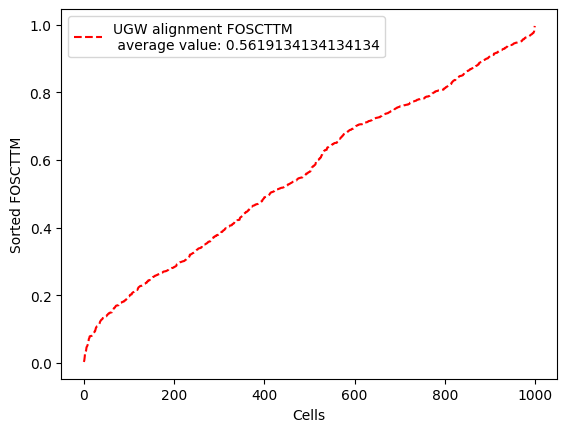

In [10]:
fracs = scootr.calc_domainAveraged_FOSCTTM(X, aligned_y.numpy())
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))
legend_label="UGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

With the newly aligned data, we can now see how the alignment looks on UMAP and PCA:

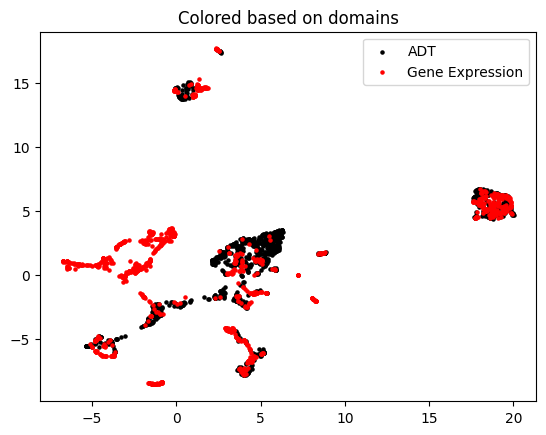

In [11]:
um = umap.UMAP(random_state=0)

Xy_um=um.fit_transform(np.concatenate((X, aligned_y.numpy()), axis=0))

X_um=Xy_um[0:1000,]
y_um=Xy_um[1000:,]

plt.scatter(X_um[:,0], X_um[:,1], c="k", s=5, label="ADT")
plt.scatter(y_um[:,0], y_um[:,1], c="r", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

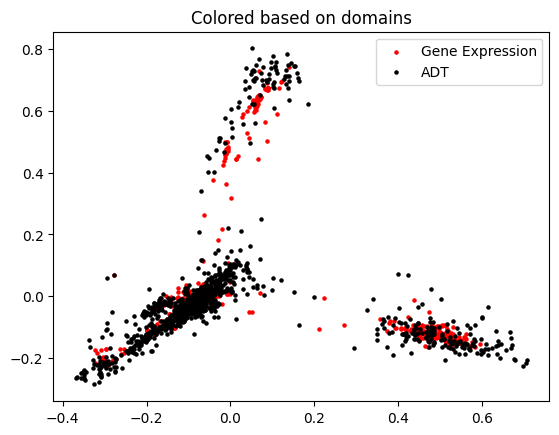

In [12]:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X, aligned_y.numpy()), axis=0))
X_pca=Xy_pca[0:1000,]
y_pca=Xy_pca[1000:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=5, label="Gene Expression")
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=5, label="ADT")
plt.legend()
plt.title("Colored based on domains")
plt.show()

Note that the alignments look nice (the shapes match up well). This property does not guarantee a good alignment, as we can see by our high original FOSCTTM score. In fact, it is more a representation of the sparsity of the coupling matrix – if the coupling matrix is very sparse, it will get close to attempting a 1-1 matching, which could be wrong (even though it is 1-1). Having a coupling matrix that is too sparse can be quite dangerous in cases where there is no underlying 1-1 sample map.

From here, we can examine the coupling matrices themselves to see what they may tell us. Given that these sample matrices are large, rather than graphing them, we will look at the rough distance between the two matrices (total difference between cells):

In [13]:
print('Total sum of pi_samp_1: {0}'.format(sum(sum(abs(pi_samp_1)))))
print('Total sum of pi_samp_2: {0}'.format(sum(sum(abs(pi_samp_2)))))
print('Total sum of differences: {0}'.format(sum(sum(abs(pi_samp_1 - pi_samp_2)))))

Total sum of pi_samp_1: 1.0000041723251343
Total sum of pi_samp_2: 1.0000029802322388
Total sum of differences: 0.014399499632418156


As we can see, the matrices are quite close; relative to their total size, they don't differ much. If these matrices converged perfectly, we would see no difference, given the symmetry of the distance matrices we discussed above.

### Entropic Regularization

Now that we have one example done, let's look at how entropic regularization and the $\epsilon$ hyperparameter change the alignment process. In addition to the main part of the cost function as described in the previous section, UGW adds an extra cost term measuring the entropy of the coupling matrix multiplied by the hyperparameter $\epsilon$. This means that, for larger values of $\epsilon$, the coupling matrix will have more entropy, meaning it will be more dense (farther from a sparse alignment of samples). In addition, the larger $\epsilon$ is, the faster Sinkhorn's algorithm will converge and produce a cost-minimizing coupling matrix. Let's see these effects in action:

```{warning}
Entropic regularization does not apply to all OT algorithms we use to solve the inner components of a BCD iteration. Sinkhorn is an example of an algorithm that depends on entropic regularization, and a common one we use to speed up alignment. However, conditional gradient descent, earth mover's distance, and majorization-minimization all do not require entropic regularization.

Although entropic regularization only really applies for the Sinkhorn algorithm, Sinkhorn is the most common method we use for OT iterations (to the point that the following section is warranted).
```

In [14]:
(pi_samp_sm, _), _, log_cost, _ = scootr.solver_fgw(Dx_knn, Dy_knn, eps=1e-5, log=True)

print(len(log_cost))

(pi_samp_med, _), _, log_cost, _ = scootr.solver_fgw(Dx_knn, Dy_knn, eps=1e-3, log=True)

print(len(log_cost))

(pi_samp_lg, _), _, log_cost, _ = scootr.solver_fgw(Dx_knn, Dy_knn, eps=1e-1, log=True)

print(len(log_cost))

20


5


2


Note the decreasing length of the cost log. The longer cost logs for higher $\epsilon$ indicate that more iterations were required for convergence to an optimal coupling matrix. This result indicates that larger values of $\epsilon$ do help with faster convergence. Now, let's align the data and examine the FOSCTTM scores for each alignment:

In [15]:
aligned_y_sm = scootr.get_barycentre(torch.from_numpy(X).to(device), pi_samp_sm)
aligned_y_med = scootr.get_barycentre(torch.from_numpy(X).to(device), pi_samp_med)
aligned_y_lg = scootr.get_barycentre(torch.from_numpy(X).to(device), pi_samp_lg)

Average FOSCTTM score for this alignment (eps=1e-5) with X onto Y is:  0.5090595595595596


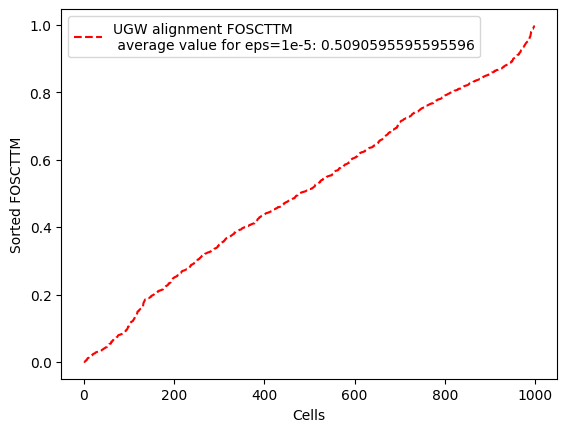

Average FOSCTTM score for this alignment (eps=1e-3) with X onto Y is:  0.5489309309309309


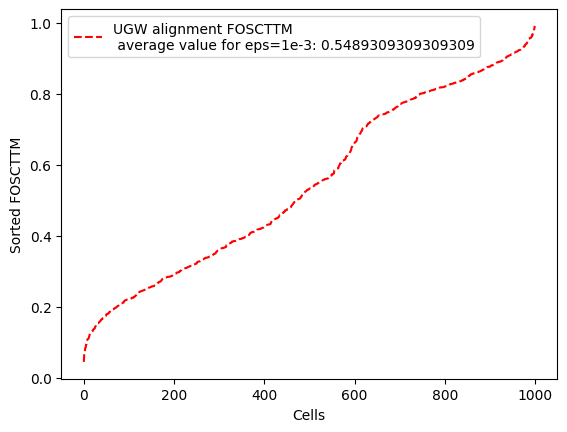

Average FOSCTTM score for this alignment (eps=1e-1) with X onto Y is:  0.41506306306306306


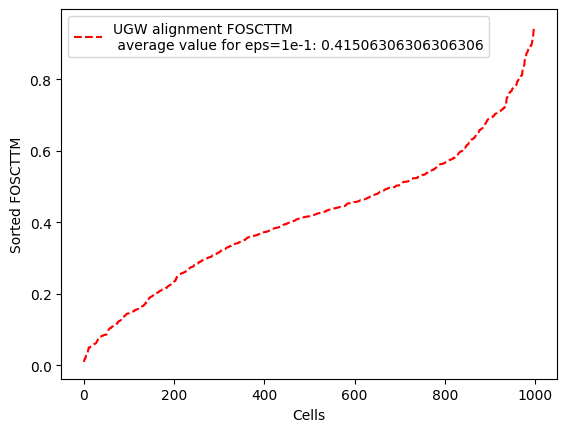

In [16]:
for aligned_y, size in [(aligned_y_sm, 'eps=1e-5'), (aligned_y_med, 'eps=1e-3'), (aligned_y_lg, 'eps=1e-1')]:
    fracs = scootr.calc_domainAveraged_FOSCTTM(X, aligned_y.numpy())
    print("Average FOSCTTM score for this alignment ({0}) with X onto Y is: ".format(size), np.mean(fracs))
    legend_label="UGW alignment FOSCTTM \n average value for {0}: ".format(size)+str(np.mean(fracs))
    plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
    plt.legend()
    plt.xlabel("Cells")
    plt.ylabel("Sorted FOSCTTM")
    plt.show()

Note that a smaller value of $\epsilon$ does not necessarily guarantee better alignment quality. In fact, since smaller $\epsilon$ encourages sparsity, it could lead to the sparsity pitfalls (confidently incorrect matchings) we looked at earlier in this section. To find the $\epsilon$ best for your particular data, you can do a search of a given log space:

In [17]:
# an example of epsilon search
pi_samp_dt = {}
pi_feat_dt = {}
# for val in np.logspace(start=-6, stop=-1, num=10):
    # (pi_samp_dt[val], _), _ = scootr.solver_fgw(Dx_knn, Dy_knn, eps=val)

From here, we will continue our investigation of $\epsilon$ by visualizing the data. We will start with the three coupling matrices.

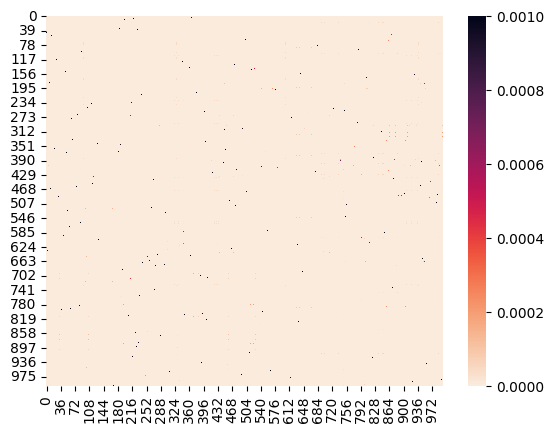

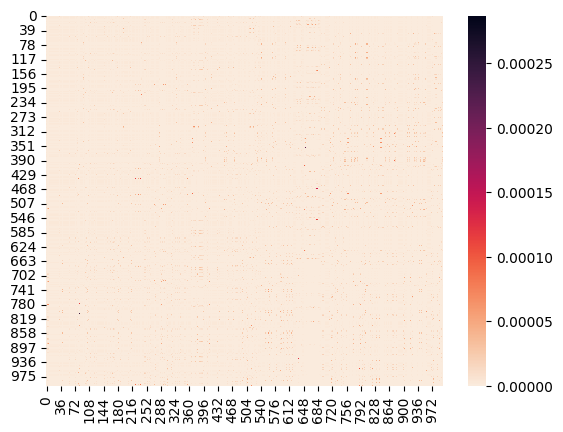

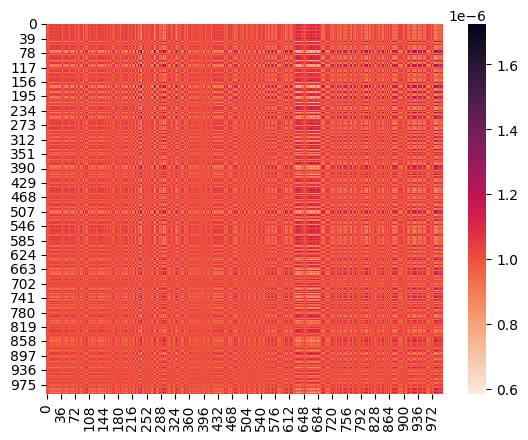

In [18]:
for pi_samp, size in [(pi_samp_sm, 'eps=1e-5'), (pi_samp_med, 'eps=1e-3'), (pi_samp_lg, 'eps=1e-1')]:    
    sns.heatmap(pi_samp, cmap='rocket_r')
    plt.show()

Note how, for the larger value of $\epsilon$, we get a much more dense coupling matrix. This result is as we expected: larger $\epsilon$ places a larger emphasis on entropy in our cost function. Let's see what these different coupling matrices mean for our UMAP visualization:

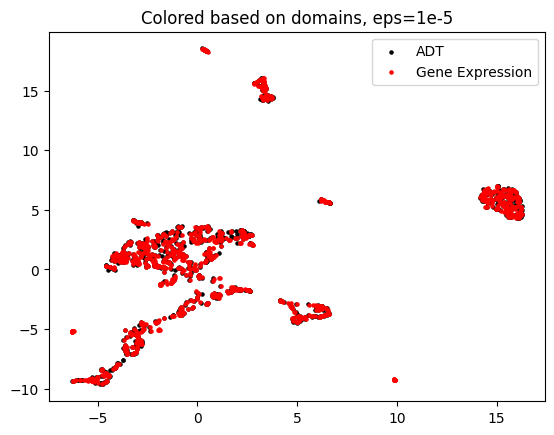

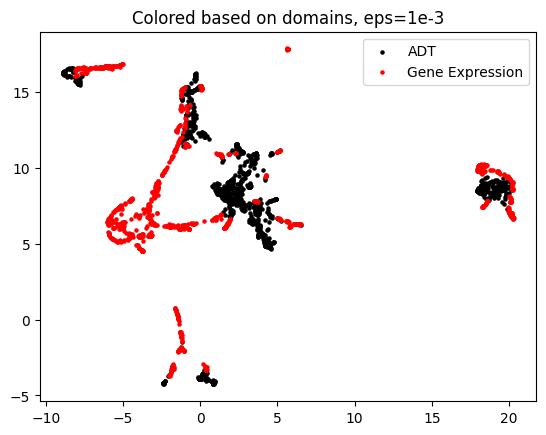

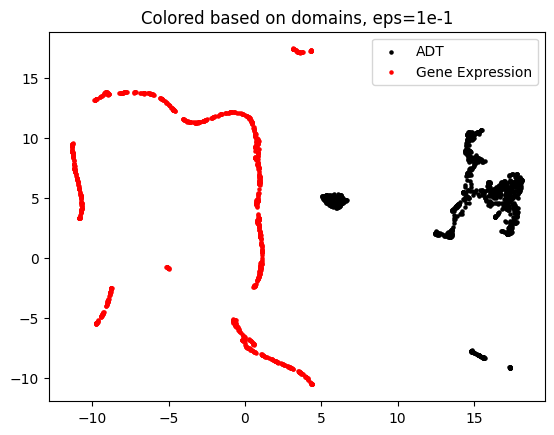

In [19]:
for aligned_y, size in [(aligned_y_sm, 'eps=1e-5'), (aligned_y_med, 'eps=1e-3'), (aligned_y_lg, 'eps=1e-1')]:    
    um = umap.UMAP(random_state=50)

    Xy_um=um.fit_transform(np.concatenate((X, aligned_y.numpy()), axis=0))

    X_um=Xy_um[0:1000,]
    y_um=Xy_um[1000:,]

    plt.scatter(X_um[:,0], X_um[:,1], c="k", s=5, label="ADT")
    plt.scatter(y_um[:,0], y_um[:,1], c="r", s=5, label="Gene Expression")
    plt.legend()
    plt.title("Colored based on domains, {0}".format(size))
    plt.show()

In the low $\epsilon$ case, we see a near 1-1 alignment (remember, this near 1-1 is likely mapping wrong cells to wrong cells in many cases) in UMAP, which is consistent with the sparse coupling matrix. As we raise $\epsilon$ to the medium case, we start to see some deviation from 1-1 alignment, and in the large $\epsilon$ case, we see something completely different. To see what is really happening in this large $\epsilon$ case, let's try linear dimensionality reduction:

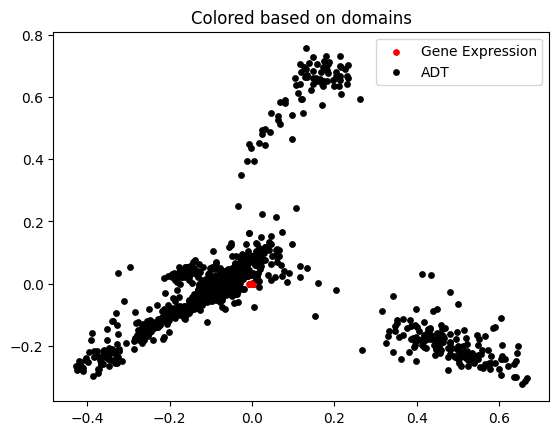

In [20]:
pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X, aligned_y_lg.numpy()), axis=0))
X_pca=Xy_pca[0:1000,]
y_pca=Xy_pca[1000:,]

# Plot aligned domains, samples colored by domain identity:
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="Gene Expression")
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="ADT")
plt.legend()
plt.title("Colored based on domains")
plt.show()

As we can see, the projected data has little to no variance with respect to the principal components of our anchor domain. We can interpret this to mean that every point in the domain being projected was projected to an average of every point in the anchor domain; since the coupling matrix was so dense, projection just led to a weighted average of points where the weights were much closer to even. So, $\epsilon$ too high and too low both have their setbacks.

```{tip}
Note that the $\epsilon$ that produces the best alignment scores on co-assayed data like this will not necessarily generalize to separate assay data; finding a good $\epsilon$ will vary case by case.
```

We can also demonstrate that the "entropic_mode" parameter doesn't matter for UGW; the distinction between 'joint' and 'independent' comes in when we are hoping to regularize coupling matrices separately, which is not the case for UGW (where we expect our coupling matrices to be similar upon convergence). See our UCOOT tutorial for more detail on this parameter. See the following for an example of how they do not differ:

In [21]:
(pi_samp_ind, _), _ = scootr.solver_fugw_simple(Dx_knn, Dy_knn, eps=1e-4, entropic_mode="independent")

(pi_samp_jnt, _), _ = scootr.solver_fugw_simple(Dx_knn, Dy_knn, eps=1e-4, entropic_mode="joint")

In [22]:
differs = False
for row in pi_samp_ind == pi_samp_jnt:
    for value in row:
        if not(value):
            differs = True
print("Are the matrices the same? {0}.".format(differs))

Are the matrices the same? True.


Now, we will move onto a different hyperparameter. The key takeaway from this section is that increasing $\epsilon$ trades higher speed for less sparsity.

### Marginal Relaxation

With a general understanding of what $\epsilon$ is doing, let's now examine the $\rho$ hyperparameter. As an argument to the UGW solver, $\rho$ will be a tuple of two values; $\rho_x$ relates to the samples in X, while $\rho_y$ relates to the samples in y. Recall that UGW treats the samples in both domains as probability distributions and decides how to move mass from one distribution to the other, producing a coupling matrix. $\rho_x$ and $\rho_y$ determine how close the coupling matrix sticks to these distributions; they determine, in some sense, how close the marginals of the coupling distribution will be to these original distributions.

Specifically, $\rho_x$ and $\rho_y$ are multiplied by respective terms that measure (in terms of KL divergence) how close the desired distribution is to the marginals of the coupling matrix. So, the larger either $\rho$ is, the closer its respective desired distribution will be to the marginals of the coupling matrix, as there will be a higher cost to differences between the distributions. In fact, we used $\rho$ = infty in the previous examples; this forces the marginals of the coupling matrix to exactly match the desired distributions (otherwise incurring a cost of infinity). Allowing $\rho$ to decrease below infinity leads to what we might call an "unbalancing" in the initial distributions, as we allow some samples to transport more or less mass than they were originally allocated. This is why we now use fugw instead of fgw – the u stands for unbalanced. Let's look at how fugw works, first on a fairly balanced set of data:

In [23]:
(pi_samp, _), duals = scootr.solver_fugw_simple(Dx_knn, Dy_knn, eps=1e-4, rho=(0.1,0.1))
aligned_y = scootr.get_barycentre(torch.from_numpy(X).to(device), pi_samp)

We can start by scoring this alignment:

Average FOSCTTM score for this alignment with X onto Y is:  0.5579354354354354


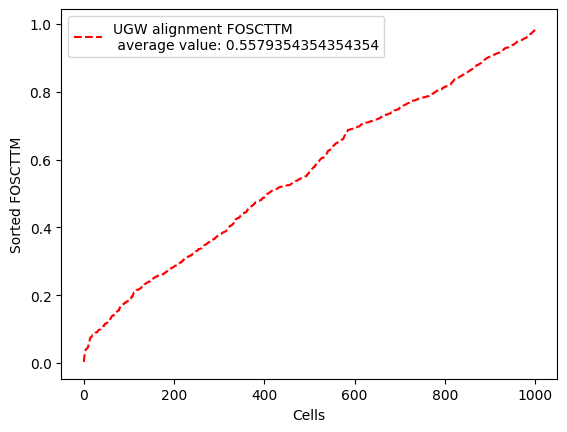

In [24]:
fracs = scootr.calc_domainAveraged_FOSCTTM(X, aligned_y.numpy())
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))
legend_label="UGW alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

And visualizing it:

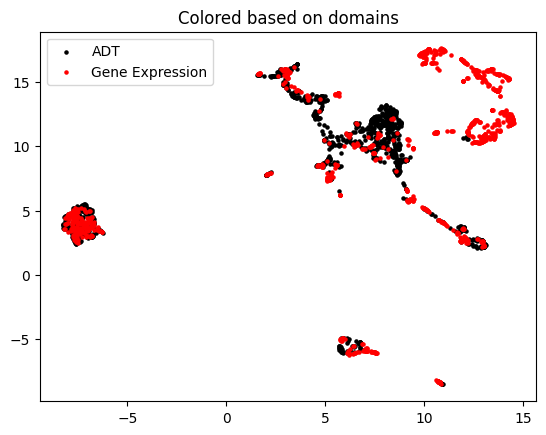

In [25]:
um = umap.UMAP()

Xy_um=um.fit_transform(np.concatenate((X, aligned_y.numpy()), axis=0))

X_um=Xy_um[0:1000,]
y_um=Xy_um[1000:,]

plt.scatter(X_um[:,0], X_um[:,1], c="k", s=5, label="ADT")
plt.scatter(y_um[:,0], y_um[:,1], c="r", s=5, label="Gene Expression")
plt.legend()
plt.title("Colored based on domains")
plt.show()

However, we can only truly get a window into $\rho$ by looking at the coupling matrix. In the uniform marginal case, which we got with fgw, each row would have the same sum, $\frac{1}{1000}$. With our new unbalancing, this is no longer the case:

In [26]:
print('Unbalanced coupling matrix: ')
for i in range(10):
    print(pi_samp[i].sum())
print('Balanced coupling matrix: ')
for i in range(10):
    print(pi_samp_ind[i].sum()) # a coupling matrix from earlier, that was balanced

Unbalanced coupling matrix: 
tensor(0.0010)
tensor(0.0010)
tensor(0.0009)
tensor(0.0010)
tensor(0.0010)
tensor(0.0009)
tensor(0.0009)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
Balanced coupling matrix: 
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)
tensor(0.0010)


In our case, where we have 1000 cells without disproportionate cell type representation across domains, unbalancing these distributions doesn't make much sense. However, if we were to have 50 cells of cell type 1 and 950 of cell type 2 in domain 1, and 500 of each in domain 2, we would want those 50 cells in domain 1 to transport much more mass. By allowing this to happen, $\rho$ makes UGW much more robust to outliers and underrepresented cell types. Note that this disproportionate example would only really happen with separately assayed datasets.

Let's see how unbalancing can help by taking 90 cells from smaller clusters in the above data and 10 cells from a larger cluster. We would expect these 10 cells to transport more mass with $\rho$ < infinity. We can begin by isolating one large cluster in the data, which we found by searching over k (and settling on k = 7) using a kneighbors graph.

In [27]:
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components

y_graph = kneighbors_graph(y, 7, mode='connectivity', metric='correlation', include_self=True)

k, labels = connected_components(y_graph, directed=False)
labels = pd.Series(labels)
labels.value_counts()

0    825
1     52
4     31
2     22
3     18
6     15
8     15
7     13
5      9
Name: count, dtype: int64

As we can see, k = 7 gives us 9 different connected clusters on the k neighbors graph. We will treat the 0 labelled cluster as our large cluster, and sample 10 from that pool; we will treat the rest as smaller clusters, and sample 90:

In [28]:
sm_clust = labels.loc[labels != 0]
lg_clust = labels.loc[labels == 0]

sm_clust_smpl = sm_clust.sample(n=90, random_state=0)
lg_clust_smpl = lg_clust.sample(n=10, random_state=0)

y_sm = y_annotated.iloc[sm_clust_smpl.index]
y_lg = y_annotated.iloc[lg_clust_smpl.index]

in_clust_vec_sm = (labels == 0).iloc[sm_clust_smpl.index]
in_clust_vec_sm.index = y_sm.index
in_clust_vec_sm.name = 'Cluster'

in_clust_vec_lg = (labels == 0).iloc[lg_clust_smpl.index]
in_clust_vec_lg.index = y_lg.index
in_clust_vec_lg.name = 'Cluster'

y_sm = pd.concat((y_sm, in_clust_vec_sm), axis=1)
y_lg = pd.concat((y_lg, in_clust_vec_lg), axis=1)

y_new = pd.concat((y_lg, y_sm))
y_new

,ITGAL,ITGAX,IL3RA,IL7R,CD14,FCGR3A,KLRB1,CD19,CCR7,IL2RA,Cluster
Cell 949,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,True
Cell 31,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,True
Cell 11,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,True
Cell 806,0.0,0.0,0.0,0.303857,0.000000,0.0,0.952718,0.0,0.000000,0.000000,True
Cell 645,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...
Cell 422,0.0,0.0,0.0,0.000638,0.000000,0.0,0.000572,0.0,0.002814,0.000000,False
Cell 716,0.0,0.0,0.0,0.000572,0.000000,0.0,0.000000,0.0,0.005041,0.999970,False
Cell 724,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.999989,False
Cell 459,0.0,0.0,0.0,0.000000,0.010771,0.0,0.000000,0.0,0.000000,0.000000,False


This process has given us a new version of our gene expression domain, which we will align with our original ADT domain. We expect that the top ten rows of the coupling matrix will transport more mass with $\rho$ < infty. Now, we can try an alignment; however, we first need a distance matrix for our new y:

In [29]:
Dy_knn_new = torch.from_numpy(scootr.knn_dist(y_new, 10).astype('float32')).to(device)

/Users/colinbaker/anaconda3/envs/scootr/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Now, we can align:

In [30]:
(pi_samp_u, _), duals = scootr.solver_fugw_simple(Dx_knn, Dy_knn_new, eps=1e-4, rho=(0.1,0.1))
(pi_samp_ctrl, _), duals = scootr.solver_fugw_simple(Dx_knn, Dy_knn_new, eps=1e-4, rho=(float('inf'), float('inf')))

From here, we can examine the coupling matrices – we care less about alignment quality and scoring, considering we now have an unbalanced case. First, let's look at a heatmap:

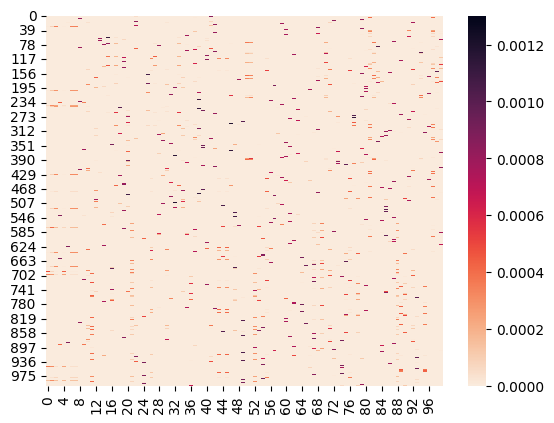

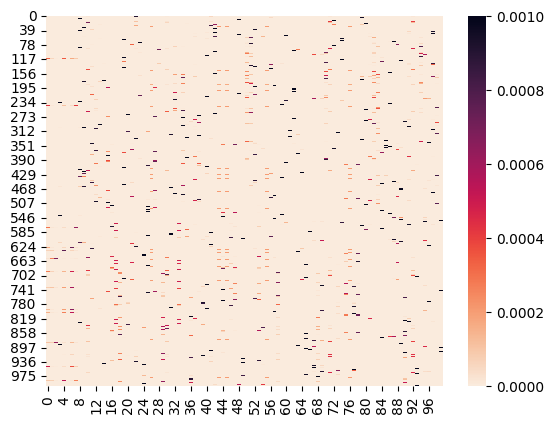

In [31]:
for pi_samp in pi_samp_u, pi_samp_ctrl:
    sns.heatmap(pi_samp, cmap='rocket_r')
    plt.show()

This visualization is not so easy to grasp; however, if we look at the column-wise sums, we can see exactly how unbalanced it is:

In [32]:
sum(pi_samp_ctrl.numpy())

array([0.01000202, 0.01000229, 0.01000199, 0.01000137, 0.01000188,
       0.01000179, 0.01000226, 0.01000216, 0.01000106, 0.01000112,
       0.01000214, 0.00999917, 0.00999715, 0.01000056, 0.01000054,
       0.00999736, 0.01000105, 0.00999898, 0.0099991 , 0.01000051,
       0.00999858, 0.00999922, 0.01000196, 0.00999686, 0.01000072,
       0.00999813, 0.01000243, 0.00999734, 0.01000053, 0.00999897,
       0.01000222, 0.01000061, 0.00999703, 0.00999891, 0.009997  ,
       0.01000048, 0.01000076, 0.01000032, 0.00999734, 0.00999875,
       0.01000056, 0.01000176, 0.01000032, 0.01000252, 0.01000105,
       0.01000237, 0.00999911, 0.01000124, 0.01000046, 0.01000078,
       0.00999686, 0.00999705, 0.00999928, 0.01000098, 0.01000046,
       0.01000225, 0.01000075, 0.01000159, 0.00999897, 0.01000004,
       0.01000047, 0.01000052, 0.0099993 , 0.01000041, 0.00999924,
       0.00999897, 0.01000062, 0.00999912, 0.00999904, 0.00999889,
       0.00999688, 0.01000206, 0.01000057, 0.00999881, 0.01000

In [33]:
sum(pi_samp_u)

tensor([0.0082, 0.0082, 0.0082, 0.0090, 0.0082, 0.0112, 0.0082, 0.0082, 0.0093,
        0.0096, 0.0098, 0.0115, 0.0076, 0.0099, 0.0104, 0.0061, 0.0082, 0.0060,
        0.0068, 0.0112, 0.0080, 0.0114, 0.0097, 0.0051, 0.0097, 0.0079, 0.0072,
        0.0062, 0.0108, 0.0081, 0.0098, 0.0114, 0.0063, 0.0060, 0.0076, 0.0106,
        0.0083, 0.0120, 0.0080, 0.0078, 0.0101, 0.0097, 0.0095, 0.0072, 0.0082,
        0.0072, 0.0057, 0.0081, 0.0108, 0.0088, 0.0055, 0.0055, 0.0115, 0.0080,
        0.0094, 0.0072, 0.0108, 0.0110, 0.0068, 0.0129, 0.0112, 0.0123, 0.0125,
        0.0106, 0.0098, 0.0063, 0.0107, 0.0103, 0.0109, 0.0103, 0.0055, 0.0098,
        0.0099, 0.0065, 0.0103, 0.0082, 0.0072, 0.0066, 0.0083, 0.0096, 0.0117,
        0.0120, 0.0055, 0.0074, 0.0110, 0.0081, 0.0116, 0.0113, 0.0114, 0.0104,
        0.0084, 0.0120, 0.0098, 0.0096, 0.0055, 0.0103, 0.0093, 0.0120, 0.0074,
        0.0113])

Didn't really work – maybe try again with more carefully selected points?

[in case I get it to work]:

As we can see above, the first ten columns in the coupling matrix have larger sums than the others, meaning they are transporting more mass – this outcome is what we predicted! We can conclude that $\rho$ is particularly helpful in cases where we have disproportionate representation of a particular subset (or subsets) of the underlying manifold shared between the two domains.


### Conclusion

With an understanding of what $\rho$ is doing, we still have one parameter left: uot_mode. UOT mode determines how we solve the problem of optimizing the coupling matrix; we have been using Sinkhorn's algorithm (uot_mode=entropic) throughout this tutorial, but we also give the option to use the Majorization-Minimization algorithm (uot_mode=mm). In SCOOTR, we give additional options, like conditional gradient descent and earth mover's distance. To read more on this topic, see the end of the UCOOT tutorial, where we do some experiments with this mode, or the SCOOTR tutorial, where we go into other available algorithms.

Now that we have gone through all of the most important pieces of how to run UGW on your own data, you can move onto our fused formulation or UCOOT tutorial. The fused formulation helps incorporate prior knowledge into the UGW/UCOOT procedures.